In [ ]:
import torch
import torch.nn as nn
import math
from typing import Optional, Union

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, config, top_k: Optional[int] = None):
        super().__init__()
        self.config = config
        self.n_heads = config.n_heads
        self.dim = config.dim
        self.dropout = nn.Dropout(p=getattr(config, "attention_dropout", 0.0))
        self.is_causal = False
        self.attention_head_size = self.dim // self.n_heads
        self.pruned_heads: set[int] = set()

        if self.dim % self.n_heads != 0:
            raise ValueError(f"n_heads ({self.n_heads}) must divide dim ({self.dim})")

        self.q_lin = nn.Linear(self.dim, self.dim)
        self.k_lin = nn.Linear(self.dim, self.dim)
        self.v_lin = nn.Linear(self.dim, self.dim)
        self.out_lin = nn.Linear(self.dim, self.dim)

        self.uniform_top_k = top_k

    def prune_heads(self, heads: list[int]):
        if not heads:
            return

        from transformers.modeling_utils import find_pruneable_heads_and_indices, prune_linear_layer

        heads_to_prune, index = find_pruneable_heads_and_indices(
            heads, self.n_heads, self.attention_head_size, self.pruned_heads
        )

        self.q_lin = prune_linear_layer(self.q_lin, index)
        self.k_lin = prune_linear_layer(self.k_lin, index)
        self.v_lin = prune_linear_layer(self.v_lin, index)
        self.out_lin = prune_linear_layer(self.out_lin, index, dim=1)

        self.n_heads -= len(heads_to_prune)
        self.dim = self.attention_head_size * self.n_heads
        self.pruned_heads = self.pruned_heads.union(heads_to_prune)

    def _prepare_heads(self, x: torch.Tensor) -> torch.Tensor:
        bs, seq_len, _ = x.size()
        return x.view(bs, seq_len, self.n_heads, self.attention_head_size).transpose(1, 2)

    def _get_uniform_sample_mask(
        self,
        k: torch.Tensor,
        top_k: Optional[int]
    ) -> Optional[torch.Tensor]:

        # Only compute if we need to sample
        if top_k is None:
            return None

        bs, n_heads, k_len, _ = k.shape
        device = k.device

        # Calculate how many tokens to sample
        effective_top_k = top_k if top_k is not None else self.uniform_top_k
        if effective_top_k is None:
            return None

        k_samples = min(int(effective_top_k), k_len)

        if k_samples >= k_len:
            # If we're sampling all tokens, no need for mask
            return torch.ones(bs, n_heads, k_len, dtype=torch.bool, device=device)

        batch_masks = []

        for b in range(bs):
            per_head_masks = []
            for h in range(n_heads):
                # Create uniform random sampling without replacement
                # Generate random permutation and take first k_samples indices
                perm = torch.randperm(k_len, device=device)
                selected_indices = perm[:k_samples]

                # Create boolean mask for selected indices
                mask = torch.zeros(k_len, dtype=torch.bool, device=device)
                mask[selected_indices] = True
                per_head_masks.append(mask)

            batch_masks.append(torch.stack(per_head_masks, dim=0))

        # Returns a boolean mask of shape (bs, n_heads, k_len)
        return torch.stack(batch_masks, dim=0)

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
        uniform_set: Optional[Union[torch.BoolTensor, torch.LongTensor]] = None,
        top_k: Optional[int] = None,
    ):
        bs, q_len, _ = query.size()
        k_len = key.size(1)
        head_dim = self.attention_head_size

        q = self._prepare_heads(self.q_lin(query))
        k = self._prepare_heads(self.k_lin(key))
        v = self._prepare_heads(self.v_lin(value))

        # (bs, n_heads, q_len, head_dim)
        q = q / math.sqrt(head_dim)
        # (bs, n_heads, q_len, k_len)
        scores = torch.matmul(q, k.transpose(-2, -1))

        # Handle masking
        if mask is not None:
            attention_mask = mask < 0  # True where masked
        else:
            attention_mask = torch.zeros(bs, 1, q_len, k_len, dtype=torch.bool, device=scores.device)

        # Compute uniform sampling mask if required
        if uniform_set is not None or top_k is not None:
            if uniform_set is not None:
                # Assuming uniform_set is a boolean mask of shape (bs, k_len) or (k_len)
                if uniform_set.dim() == 1:
                    mask_keep = uniform_set.view(1, 1, 1, k_len).expand(bs, self.n_heads, q_len, k_len)
                else:
                    mask_keep = uniform_set.view(bs, 1, 1, k_len).expand(bs, self.n_heads, q_len, k_len)
            else:
                # mask_keep will have shape (bs, n_heads, k_len)
                mask_keep = self._get_uniform_sample_mask(k, top_k)
                # Reshape to (bs, n_heads, 1, k_len) for broadcasting
                mask_keep = mask_keep.unsqueeze(2).expand(bs, self.n_heads, q_len, k_len)

            # Combine masks: we mask out a token if it's masked by the original mask OR if it's not in the uniform sample
            attention_mask = attention_mask | ~mask_keep

        # Apply the final combined mask
        scores.masked_fill_(attention_mask, torch.finfo(scores.dtype).min)

        # Standard softmax attention
        weights = nn.functional.softmax(scores, dim=-1)
        weights = self.dropout(weights)

        if head_mask is not None:
            weights = weights * head_mask

        context = torch.matmul(weights, v)
        context = context.transpose(1, 2).contiguous().view(bs, q_len, self.dim)
        context = self.out_lin(context)

        if output_attentions:
            return (context, weights)

        return (context,)

In [ ]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch

# Define the model checkpoint you want to use
model_checkpoint = "distilbert/distilbert-base-cased-distilled-squad"

# Load the correct FAST tokenizer for the CASED model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Load the model WITH THE QUESTION ANSWERING HEAD
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

In [ ]:
#mha with kev attention, remove this cell for vanilla
device = "cuda" if torch.cuda.is_available() else "cpu"
for i, layer in enumerate(model.distilbert.transformer.layer):
    custom_attention = MultiHeadSelfAttention(model.config, top_k=32)
    custom_attention.q_lin.load_state_dict(layer.attention.q_lin.state_dict())
    custom_attention.k_lin.load_state_dict(layer.attention.k_lin.state_dict())
    custom_attention.v_lin.load_state_dict(layer.attention.v_lin.state_dict())
    custom_attention.out_lin.load_state_dict(layer.attention.out_lin.state_dict())
    custom_attention.to(device)
    layer.attention = custom_attention

print("loaded")

loaded


In [ ]:
from datasets import load_dataset

ds = load_dataset("squad")

ds

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [ ]:
train_dataset = ds['train']
validation_dataset = ds['validation']

def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]

    # Tokenize the question and context together
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Store the sample mapping BEFORE popping it
    sample_map = inputs["overflow_to_sample_mapping"]

    offset_mapping = inputs.pop("offset_mapping")
    inputs.pop("overflow_to_sample_mapping")  # Remove from main inputs but we keep sample_map

    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]  # Use the stored sample_map
        answer = examples["answers"][sample_idx]

        # Get the character start and end of the answer
        start_char = answer["answer_start"][0]
        end_char = start_char + len(answer["text"][0])

        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        context_start = 0
        context_end = len(sequence_ids) - 1

        # Find where the context actually starts and ends
        while context_start < len(sequence_ids) and sequence_ids[context_start] != 1:
            context_start += 1
        while context_end >= 0 and sequence_ids[context_end] != 1:
            context_end -= 1

        # If the answer is not fully inside the context, label it (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Find the token start and end positions
            token_start_index = context_start
            while token_start_index <= context_end and offset[token_start_index][0] <= start_char:
                token_start_index += 1
            start_positions.append(token_start_index - 1)

            token_end_index = context_end
            while token_end_index >= context_start and offset[token_end_index][1] >= end_char:
                token_end_index -= 1
            end_positions.append(token_end_index + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    inputs["sample_mapping"] = sample_map  # Add it back with a different name

    return inputs

# Apply the preprocessing
tokenized_validation = validation_dataset.map(preprocess_function, batched=True, remove_columns=validation_dataset.column_names)

# Convert to PyTorch Tensors and create DataLoader
from torch.utils.data import DataLoader, TensorDataset

val_ids = torch.tensor(tokenized_validation['input_ids'])
val_attention_mask = torch.tensor(tokenized_validation['attention_mask'])
# We don't need labels for the inference itself, but we'll use them for evaluation later

pin = torch.cuda.is_available()
# Note: For QA, the DataLoader yields only input_ids and attention_mask.
# The original examples are needed for evaluation.
dataset = TensorDataset(val_ids, val_attention_mask)
test_loader = DataLoader(dataset, batch_size=64, shuffle=False, pin_memory=pin)

Map:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [ ]:
!pip install codecarbon --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.2/291.2 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 9.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
firebase-admin 6.9.0 requires httpx[http2]==0.28.1, but you have httpx 0.27.2 which is incompatible.
google-genai 1.39.1 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.


In [ ]:
!pip install evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.5 MB/s eta 0:00:00


In [ ]:
import codecarbon
import torch
import pandas as pd
import time
import os
from tqdm.notebook import tqdm
from transformers import DistilBertForQuestionAnswering
from torch.utils.data import DataLoader, TensorDataset
import evaluate # Using the new Hugging Face evaluate library
from collections import defaultdict
# --- Constants ---
RESULTS_DIR = "./test_results"
CARBON_DIR = "./carbon_emissions"
RESULTS_FILE = os.path.join(RESULTS_DIR, "qa_inference_metrics.csv")
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(CARBON_DIR, exist_ok=True)


def simple_qa_inference(model, dataset, tokenizer, device, num_examples=None):
    """
    Simple QA inference function that processes examples one by one
    """
    if num_examples is None:
        num_examples = len(dataset)

    model.eval()
    predictions = []
    references = []
    batch_times = []
    memory_usage = []

    with torch.no_grad():
        for i in tqdm(range(min(num_examples, len(dataset))), desc="QA Inference"):
            example = dataset[i]
            question = example["question"]
            context = example["context"]

            # Tokenize
            inputs = tokenizer(question, context, return_tensors="pt", truncation=True, padding=True, max_length=384)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Time the inference
            batch_start = time.time()
            outputs = model(**inputs)
            batch_times.append(time.time() - batch_start)

            # Track memory usage
            if torch.cuda.is_available():
                memory_used = torch.cuda.max_memory_allocated() / (1024**3)
                memory_usage.append(memory_used)
                torch.cuda.reset_peak_memory_stats()

            # Get most likely answer
            start_logits = outputs.start_logits
            end_logits = outputs.end_logits

            start_idx = torch.argmax(start_logits, dim=1).item()
            end_idx = torch.argmax(end_logits, dim=1).item()

            # Decode answer
            input_ids = inputs["input_ids"][0]
            answer_tokens = input_ids[start_idx:end_idx+1]
            answer_text = tokenizer.decode(answer_tokens, skip_special_tokens=True)

            predictions.append({
                'id': example['id'],
                'prediction_text': answer_text
            })
            references.append({
                'id': example['id'],
                'answers': example['answers']
            })

    return predictions, references, batch_times, memory_usage

# --- Main Execution ---
# Initialize the carbon tracker
tracker = codecarbon.EmissionsTracker(output_dir=CARBON_DIR, project_name="QA_Inference", log_level="critical")
tracker.start()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Using device: {device}")

# Run the simple inference
predictions, references, batch_times, memory_usage = simple_qa_inference(
    model=model,
    dataset=validation_dataset,
    tokenizer=tokenizer,
    device=device,
    num_examples=len(validation_dataset)  # Adjust this number as needed
)

# Stop the tracker and get emissions
emissions_kg = tracker.stop()

# Compute metrics
squad_metric = evaluate.load("squad")
qa_metrics = squad_metric.compute(predictions=predictions, references=references)

# Calculate timing metrics
total_inference_time = sum(batch_times)
avg_batch_time = total_inference_time / len(batch_times) if batch_times else 0
avg_memory_used = sum(memory_usage) / len(memory_usage) if memory_usage else 0

# Compile all metrics
metrics = {
    'total_inference_time': total_inference_time,
    'avg_batch_time': avg_batch_time,
    'emissions_kg': emissions_kg,
    'exact_match': qa_metrics['exact_match'],
    'f1': qa_metrics['f1'],
    'avg_memory_used_gb': avg_memory_used,
    'num_examples_processed': len(predictions)
}

# Save metrics to CSV
pd.DataFrame([metrics]).to_csv(RESULTS_FILE, index=False)

# Print results
print(f"\n🎯 QA Inference Complete!")
print(f"📊 Number of examples processed: {metrics['num_examples_processed']}")
print(f"⏰ Total Time: {metrics['total_inference_time']:.2f}s")
print(f"📦 Average batch time: {metrics['avg_batch_time']:.4f}s")
print(f"🌱 Emissions: {metrics['emissions_kg']:.6f} kg CO2")
print(f"💾 Average memory used: {metrics['avg_memory_used_gb']:.2f} GB")
print(f"🎯 Exact Match: {metrics['exact_match']:.4f}")
print(f"📈 F1 Score: {metrics['f1']:.4f}")

print(f"\n📁 Results saved to: {RESULTS_FILE}")


[codecarbon WARNING @ 20:14:15] Multiple instances of codecarbon are allowed to run at the same time.


Using device: cuda


QA Inference:   0%|          | 0/10570 [00:00<?, ?it/s]


🎯 QA Inference Complete!
📊 Number of examples processed: 10570
⏰ Total Time: 105.65s
📦 Average batch time: 0.0100s
🌱 Emissions: 0.000572 kg CO2
💾 Average memory used: 0.26 GB
🎯 Exact Match: 70.9839
📈 F1 Score: 80.2265

📁 Results saved to: ./test_results/qa_inference_metrics.csv


In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [ ]:
import pandas as pd

pd.read_csv("/content/test_results/qa_inference_metrics.csv")

,total_inference_time,avg_batch_time,emissions_kg,exact_match,f1,avg_memory_used_gb,num_examples_processed
0,105.649457,0.009995,0.000572,70.983917,80.226476,0.259839,10570


In [ ]:
question, text = "Who was Jim Henson?", "Jim Henson was a nice puppet"

inputs = tokenizer(question, text, return_tensors="pt")
inputs.to(device)
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)

In [ ]:
attentions=outputs.attentions

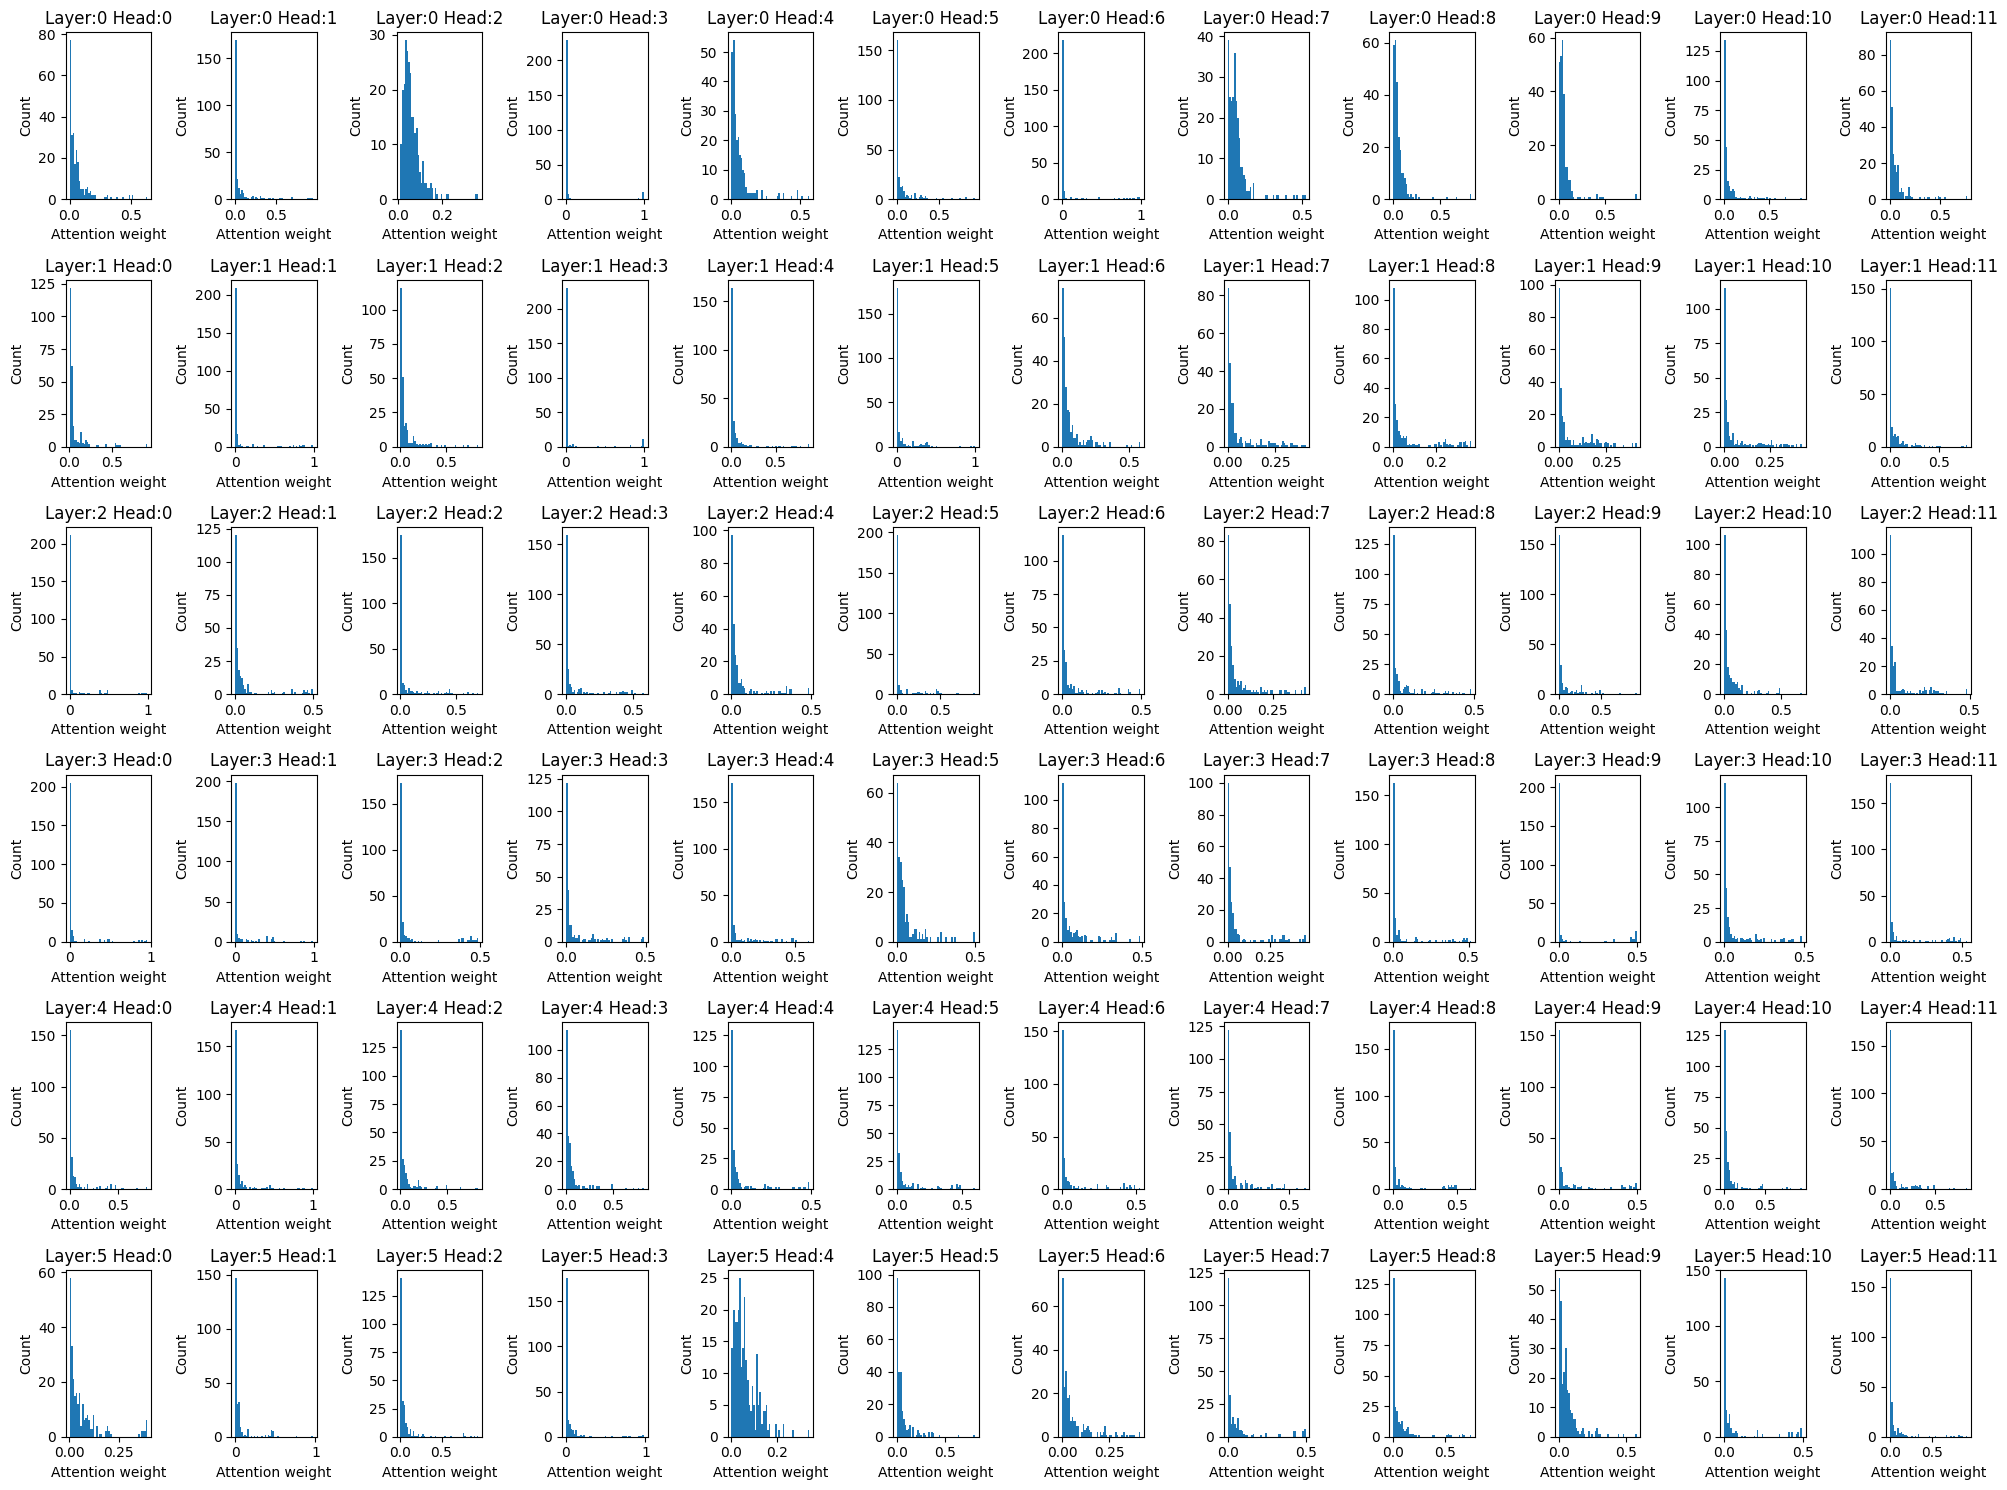

In [ ]:
import matplotlib.pyplot as plt
#hist layer vise
num_layers = len(attentions)
num_heads = attentions[0].size(1)

fig, axes = plt.subplots(num_layers, num_heads, figsize=(20, 15))

for layer_idx, layer_attn in enumerate(attentions):
    # Take first example from batch (instead of averaging)
    attn = layer_attn[0]  # shape: [num_heads, seq_len, seq_len]

    for head_idx in range(num_heads):
        values = attn[head_idx].detach().cpu().numpy().flatten()

        ax = axes[layer_idx, head_idx] if num_layers > 1 else axes[head_idx]
        ax.hist(values, bins=50)  # zoom in on [0, 0.3]
        ax.set_title(f"Layer:{layer_idx} Head:{head_idx}")
        ax.set_xlabel("Attention weight")
        ax.set_ylabel("Count")

plt.tight_layout()
plt.savefig('uniform_hist_qa.png')
plt.show()


In [ ]:
!pip install bertviz --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 128.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.0 MB/s eta 0:00:00


In [ ]:
input = inputs

In [ ]:
# Convert all sequences in batch
all_tokens = [
    tokenizer.convert_ids_to_tokens(seq.tolist())
    for seq in input["input_ids"]
]

for i, tokens in enumerate(all_tokens):
    print(f"Sequence {i} tokens:", tokens)


Sequence 0 tokens: ['[CLS]', 'Who', 'was', 'Jim', 'He', '##nson', '?', '[SEP]', 'Jim', 'He', '##nson', 'was', 'a', 'nice', 'puppet', '[SEP]']


In [ ]:
import torch
from bertviz import head_view

# choose the first sequence in batch
seq_index = 0

# stack attentions across layers into [num_layers, num_heads, seq, seq]
attention_stack = torch.stack([layer[seq_index] for layer in attentions])

# add batch dimension → [num_layers, 1, num_heads, seq, seq]
attention_stack = attention_stack.unsqueeze(1)

# tokens for that sequence
tokens = all_tokens[seq_index]

# visualize
head_view(attention_stack, tokens, sentence_b_start=None)


<IPython.core.display.Javascript object>

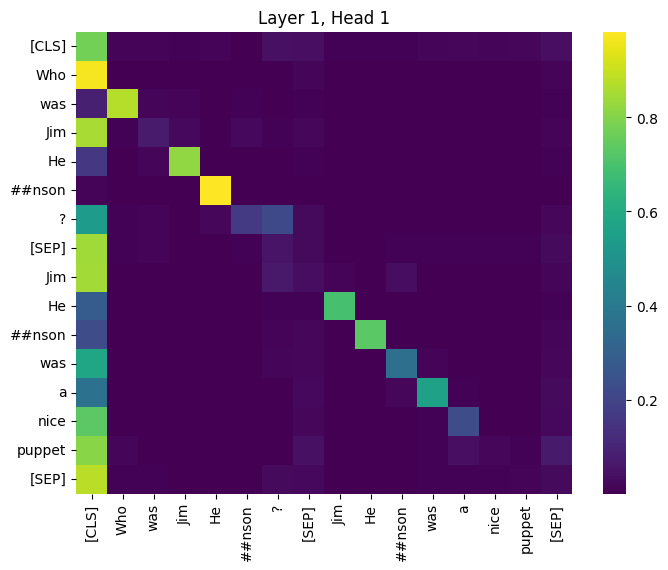

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

layer, head = 1,1
weights = attention_stack[layer, 0, head].detach().cpu()

plt.figure(figsize=(8, 6))
sns.heatmap(weights, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title(f"Layer {layer}, Head {head}")
plt.savefig("head_heat_uniform_qa.png")
plt.show()


In [ ]:
from bertviz import model_view
model_view(attention_stack,tokens)

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

# ---------- 1) tokens for all sequences ----------
def tokens_for_all(inputs, tokenizer):
    all_token_lists = []
    ids = inputs["input_ids"]  # shape [batch, seq_len]
    for seq in ids:
        seq_list = seq.tolist()
        tokens = tokenizer.convert_ids_to_tokens(seq_list)
        all_token_lists.append(tokens)
    return all_token_lists

# ---------- 2) heatmap for a single layer/head ----------
def plot_attention_heatmap(attentions, inputs, tokenizer, layer=0, head=0, seq_index=0, figsize=(8,6), cmap='viridis'):
    attn = attentions[layer][seq_index, head]   # shape [seq_len, seq_len]
    attn_np = attn.detach().cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][seq_index].tolist())

    plt.figure(figsize=figsize)
    sns.heatmap(attn_np, xticklabels=tokens, yticklabels=tokens, square=True, cbar=True, cmap=cmap)
    plt.title(f"Layer {layer} Head {head} (seq {seq_index})")
    plt.xlabel("Key tokens")
    plt.ylabel("Query tokens")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig("heat_sing_uniform_qa.png")  # title: heat_sing_uniform_qa
    plt.show()

# ---------- 3) grid of head heatmaps for one layer ----------
def plot_layer_heads(attentions, inputs, tokenizer, layer=0, seq_index=0, max_heads=12, figsize_per_plot=(3,3)):
    heads = attentions[layer].size(1)
    heads = min(heads, max_heads)
    cols = min(6, heads)
    rows = int(np.ceil(heads / cols))
    fig_w = cols * figsize_per_plot[0]
    fig_h = rows * figsize_per_plot[1]
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h))
    axes = axes.flatten()
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][seq_index].tolist())

    for h in range(heads):
        ax = axes[h]
        attn_np = attentions[layer][seq_index, h].detach().cpu().numpy()
        sns.heatmap(attn_np, ax=ax, cbar=False, xticklabels=tokens, yticklabels=tokens)
        ax.set_title(f"Layer:{layer} Head:{h}")
        ax.set_xticks([])
        ax.set_yticks([])

    for i in range(heads, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.savefig("grid_unfirm_qa.png")  # title: grid_unfirm_qa
    plt.show()

# ---------- 4) histogram distributions per head ----------
def plot_histograms(attentions, seq_index=0, bins=50, value_range=(0,0.3)):
    num_layers = len(attentions)
    num_heads = attentions[0].size(1)
    fig, axes = plt.subplots(num_layers, num_heads, figsize=(num_heads*2, num_layers*1.8))
    for l, layer_attn in enumerate(attentions):
        attn = layer_attn[seq_index]  # [heads, seq_len, seq_len]
        for h in range(num_heads):
            ax = axes[l, h] if num_layers>1 else axes[h]
            vals = attn[h].detach().cpu().numpy().flatten()
            ax.hist(vals, bins=bins, range=value_range)
            ax.set_title(f"Layer:{l} Head:{h}")
            ax.set_xlim(value_range)
            ax.set_ylim(0, None)
            ax.set_xticks([value_range[0], value_range[1]])
    plt.tight_layout()
    plt.savefig("hist_uniform_qa.png")  # title: hist_uniform_qa
    plt.show()

# ---------- 5) attention rollout ----------
def attention_rollout(attentions, discard_ratio=0.0):
    avg_per_layer = [layer_attn.mean(1) for layer_attn in attentions]  # [batch, seq, seq]
    batch = avg_per_layer[0].size(0)
    seq_len = avg_per_layer[0].size(1)
    device = avg_per_layer[0].device  # FIXED DEVICE
    rollouts = []
    for b in range(batch):
        joint = torch.eye(seq_len, device=device)  # FIXED DEVICE
        for L in avg_per_layer:
            A = L[b]
            if discard_ratio > 0:
                flat = A.flatten()
                thresh = torch.quantile(flat, discard_ratio)
                A = torch.where(A < thresh, torch.zeros_like(A), A)
            A = A + torch.eye(seq_len, device=A.device)  # FIXED DEVICE
            A = A / A.sum(dim=-1, keepdim=True)
            joint = A @ joint
        rollouts.append(joint.detach().cpu().numpy())
    return rollouts

def plot_rollout(rollouts, inputs, tokenizer, seq_index=0):
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][seq_index].tolist())
    mat = rollouts[seq_index]
    plt.figure(figsize=(8,6))
    sns.heatmap(mat, xticklabels=tokens, yticklabels=tokens, square=True, cbar=True)
    plt.title("Attention rollout (token influence)")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig("rollout_uniform_qa.png")  # title: rollout_uniform_qa
    plt.show()

# ---------- 6) head similarity matrix ----------
from sklearn.metrics.pairwise import cosine_similarity
def head_similarity_matrix(attentions, layer, seq_index=0):
    layer_attn = attentions[layer][seq_index]  # [heads, seq, seq]
    H = layer_attn.size(0)
    patterns = []
    for h in range(H):
        pat = layer_attn[h].detach().cpu().numpy().flatten()
        patterns.append(pat)
    sim = cosine_similarity(patterns)
    return sim

def plot_head_similarity(sim, layer):
    plt.figure(figsize=(6,5))
    sns.heatmap(sim, annot=True, fmt=".2f")
    plt.title(f"Head similarity (Layer {layer})")
    plt.xlabel("Head")
    plt.ylabel("Head")
    plt.tight_layout()
    plt.savefig("similarity_uniform_qa.png")  # title: similarity_uniform_qa
    plt.show()

# ---------- 7) per-head CLS mass ----------
def cls_mass_per_head(attentions, inputs, cls_index=0, seq_index=0):
    masses = []
    for l, layer_attn in enumerate(attentions):
        a = layer_attn[seq_index]  # [heads, seq, seq]
        mass_to_cls = a[:, :, cls_index].sum(axis=1).detach().cpu().numpy()
        masses.append(mass_to_cls)
    return np.stack(masses, axis=0)  # [layers, heads]

def plot_cls_mass(mass_matrix):
    layers, heads = mass_matrix.shape
    plt.figure(figsize=(heads*0.5 + 3, layers*0.4 + 2))
    sns.heatmap(mass_matrix, annot=False, cmap='magma')
    plt.xlabel("Head")
    plt.ylabel("Layer")
    plt.title("Per-head mass attending TO CLS (rows=layers)")
    plt.tight_layout()
    plt.savefig("cls_mass_uniform_qa.png")  # title: cls_mass_uniform_qa
    plt.show()


batch size: 1


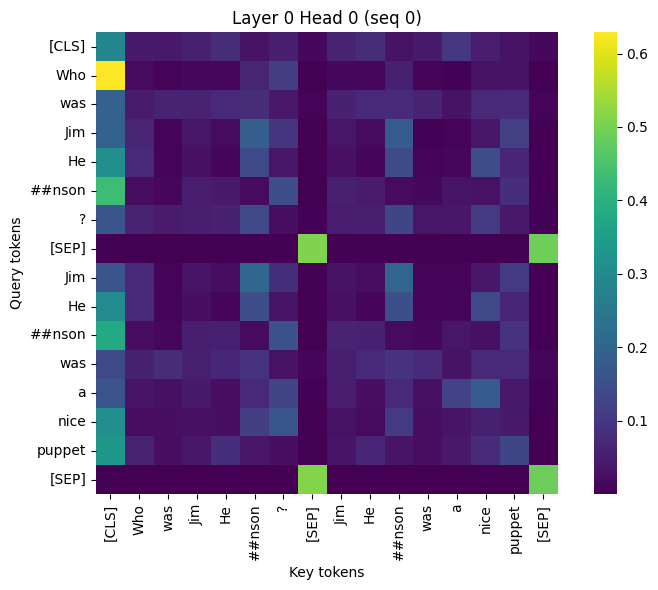

In [ ]:
# assume tokenizer, model loaded; inputs tokenized; outputs computed
output = outputs
attentions = output.attentions
all_tokens = tokens_for_all(input, tokenizer)
print("batch size:", len(all_tokens))

# Plot a single heatmap
plot_attention_heatmap(attentions, input, tokenizer, layer=0, head=0, seq_index=0)



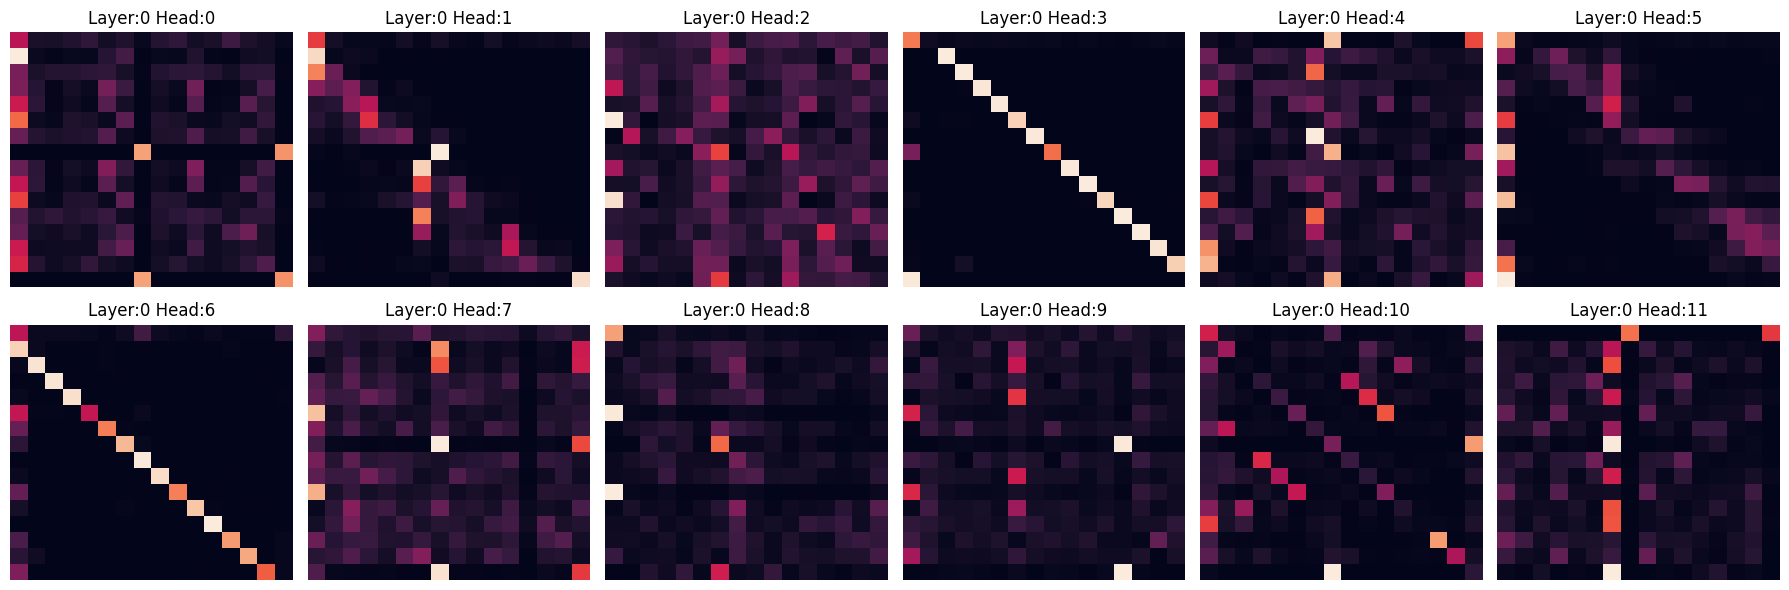

In [ ]:
# Plot grid of heads for layer 0, example 0
plot_layer_heads(attentions, input, tokenizer, layer=0, seq_index=0)



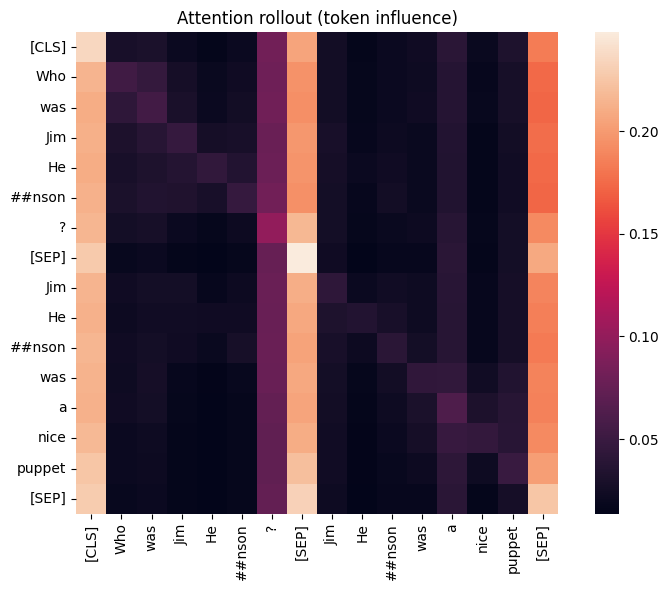

In [ ]:
# Attention rollout and plot
rollouts = attention_rollout(attentions, discard_ratio=0.0)
plot_rollout(rollouts, input,tokenizer=tokenizer, seq_index=0)



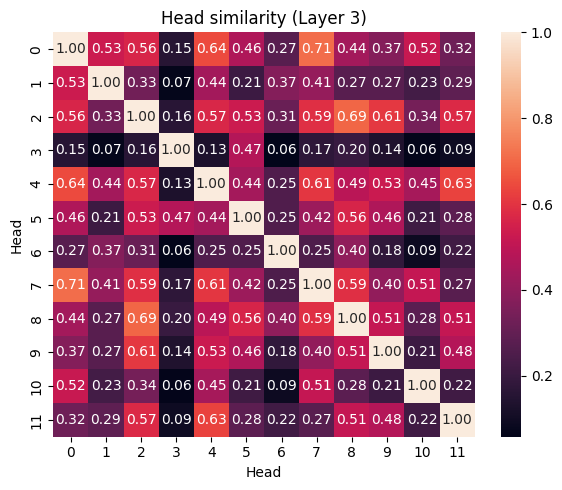

In [ ]:
# Head similarity & visualization
sim = head_similarity_matrix(attentions, layer=0, seq_index=0)
plot_head_similarity(sim, layer=3)


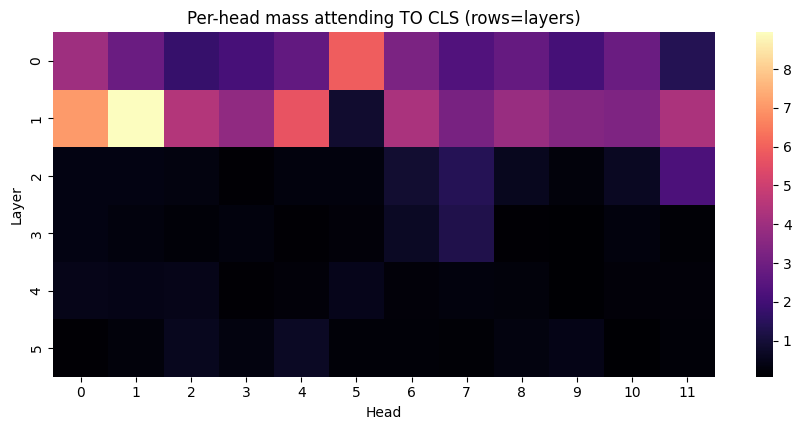

In [ ]:

# CLS mass across layers
mass = cls_mass_per_head(attentions, input, cls_index=0, seq_index=0)
plot_cls_mass(mass)

In [ ]:
!pip install captum --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 118.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


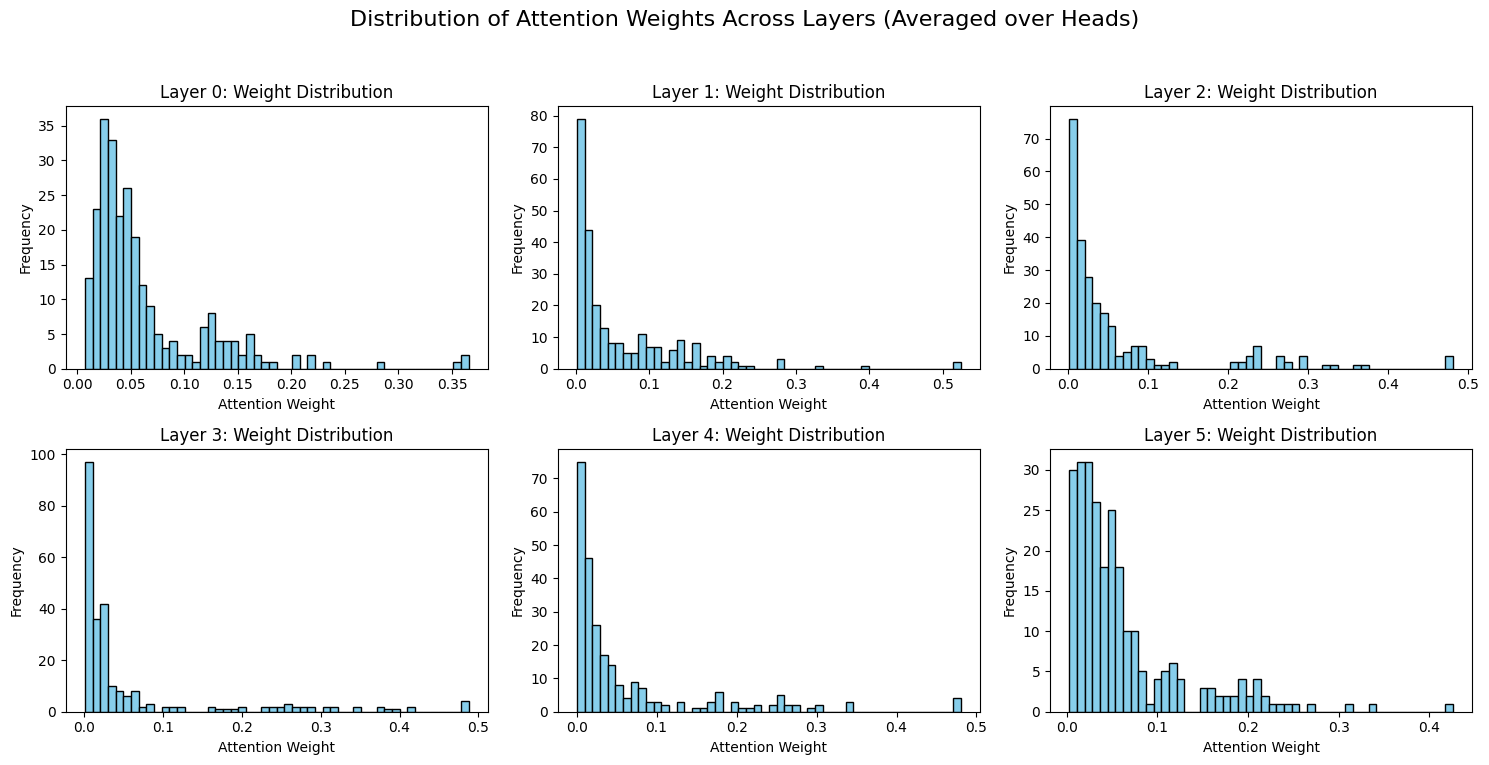

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, layer_attention in enumerate(attentions):
    # Get attention for the first (and only) item in the batch
    # and average across all heads: shape becomes [seq_len, seq_len]
    layer_attention_avg = layer_attention[0].mean(dim=0)

    # Flatten the matrix to get a 1D array of weights
    weights = layer_attention_avg.detach().cpu().numpy().flatten()

    ax = axes[i]
    ax.hist(weights, bins=50, color='skyblue', edgecolor='black')
    ax.set_title(f'Layer {i}: Weight Distribution')
    ax.set_xlabel('Attention Weight')
    ax.set_ylabel('Frequency')

plt.suptitle('Distribution of Attention Weights Across Layers (Averaged over Heads)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("layerwise_avg_uniform_qa.png")  # title: layerwise_avg_uniform_qa
plt.show()


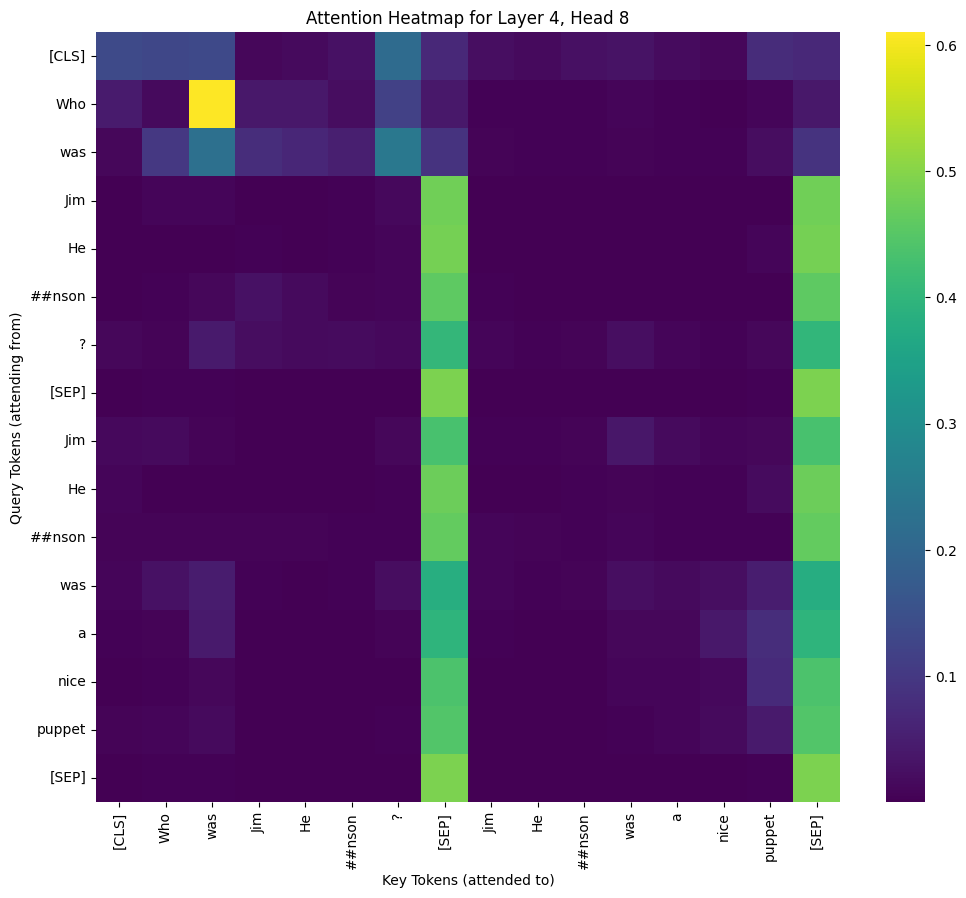

In [ ]:
# --- You can change these values to explore different layers/heads ---
LAYER_TO_VISUALIZE = 4
HEAD_TO_VISUALIZE = 8
# -------------------------------------------------------------------

# Get attention weights for the specific layer and head
attention_weights = attentions[LAYER_TO_VISUALIZE][0, HEAD_TO_VISUALIZE].detach().cpu().numpy()

plt.figure(figsize=(12, 10))
sns.heatmap(attention_weights, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title(f'Attention Heatmap for Layer {LAYER_TO_VISUALIZE}, Head {HEAD_TO_VISUALIZE}')
plt.xlabel("Key Tokens (attended to)")
plt.ylabel("Query Tokens (attending from)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

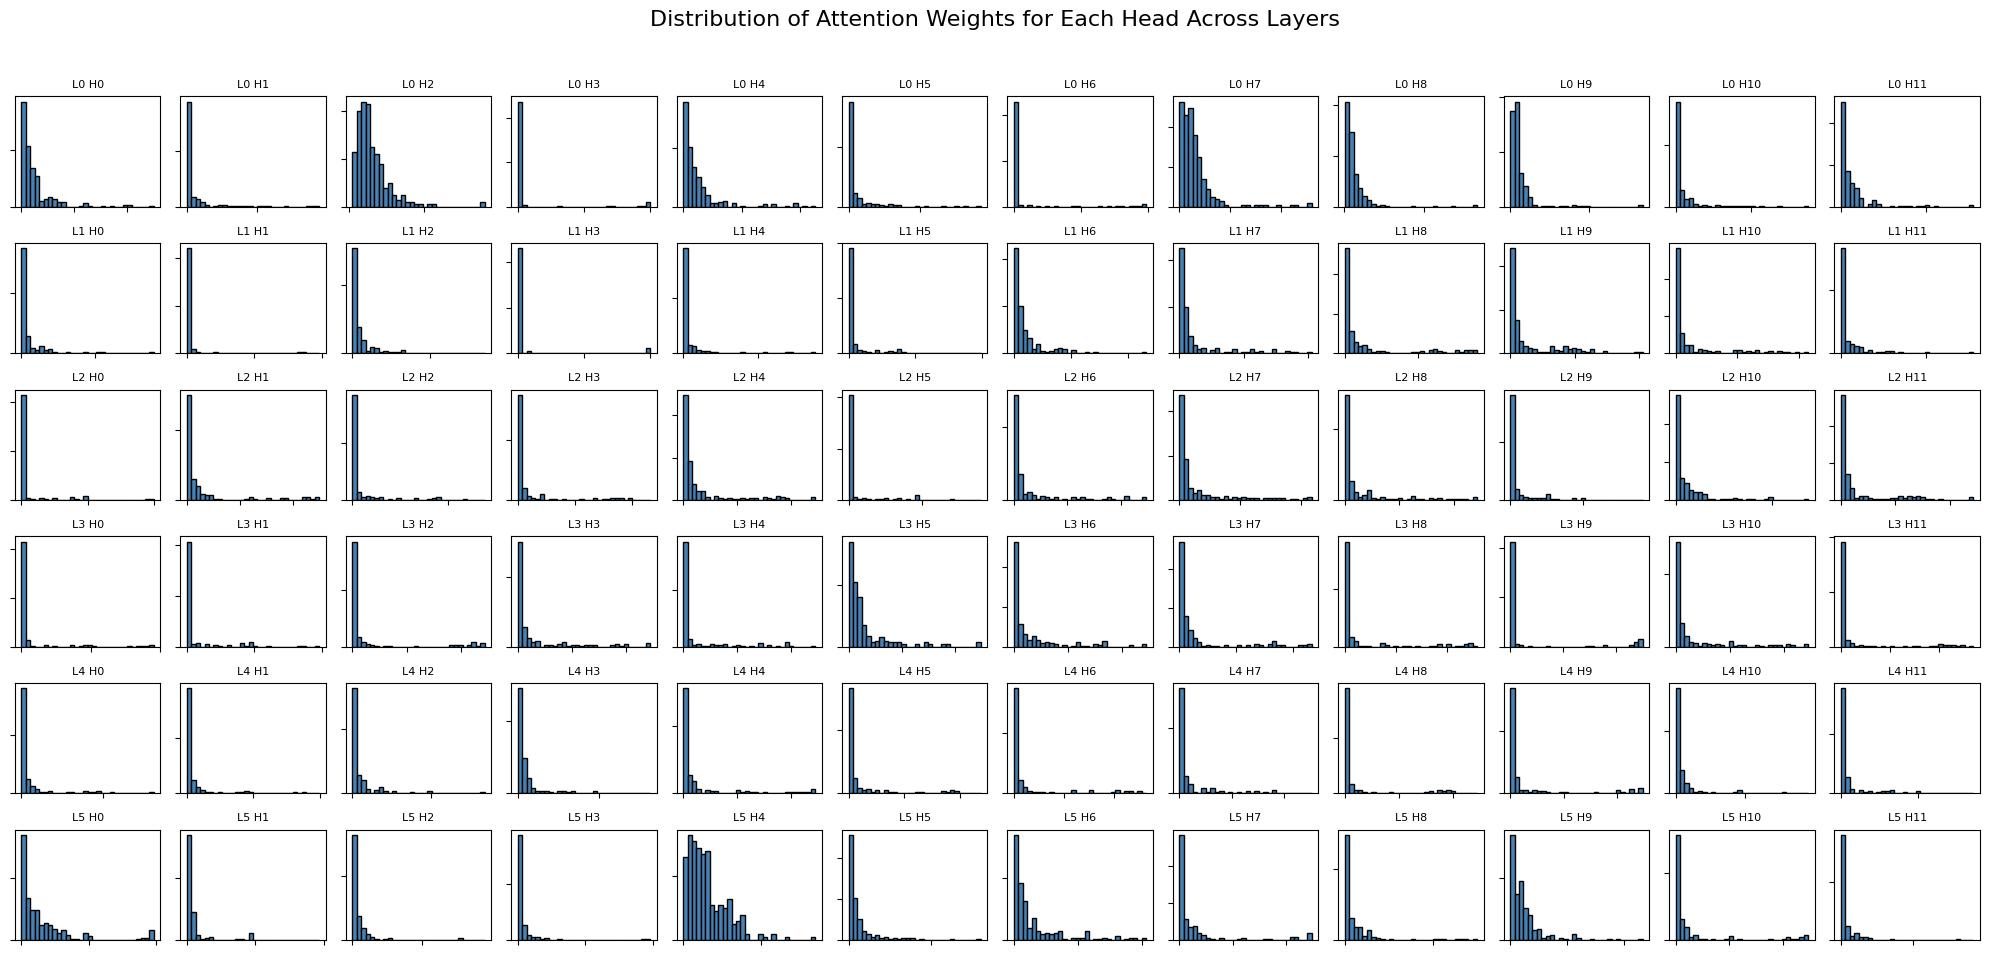

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, layer_attention in enumerate(attentions):
    # Get attention for the first (and only) item in the batch
    # and average across all heads: shape becomes [seq_len, seq_len]
    layer_attention_avg = layer_attention[0].mean(dim=0)

    # Flatten the matrix to get a 1D array of weights
    weights = layer_attention_avg.detach().cpu().numpy().flatten()

    ax = axes[i]
    ax.hist(weights, bins=50, color='skyblue', edgecolor='black')
    ax.set_title(f'Layer {i}: Weight Distribution')
    ax.set_xlabel('Attention Weight')
    ax.set_ylabel('Frequency')

plt.suptitle('Distribution of Attention Weights Across Layers (Averaged over Heads)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("layerwise_avg_uniform_qa.png")  # title: layerwise_avg_uniform_qa
plt.show()


In [ ]:
!pip install transformers-interpret --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.9 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers_interpret import QuestionAnsweringExplainer

# --- 1. Load your model and tokenizer (same as before) ---
model_checkpoint = "distilbert/distilbert-base-cased-distilled-squad"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

# --- 2. Define your example data ---
question = "What is the capital of France?"
context = "Paris is the capital and most populous city of France, with an estimated population of 2,165,423 residents as of 2022."

# --- 3. Get the model's prediction (we need to know what to explain) ---
inputs = tokenizer(question, context, return_tensors='pt')
with torch.no_grad():
    outputs = model(**inputs)
start_idx = torch.argmax(outputs.start_logits)
end_idx = torch.argmax(outputs.end_logits)
predicted_answer_tokens = inputs.input_ids[0, start_idx : end_idx + 1]
predicted_answer = tokenizer.decode(predicted_answer_tokens)

# --- 4. Use the Explainer ---
# Initialize the explainer for Question Answering
qa_explainer = QuestionAnsweringExplainer(model, tokenizer)

# Get attributions (saliency scores) for the predicted answer
word_attributions = qa_explainer(question, context, predicted_answer)

# The library comes with a powerful, built-in visualizer!
qa_explainer.visualize()

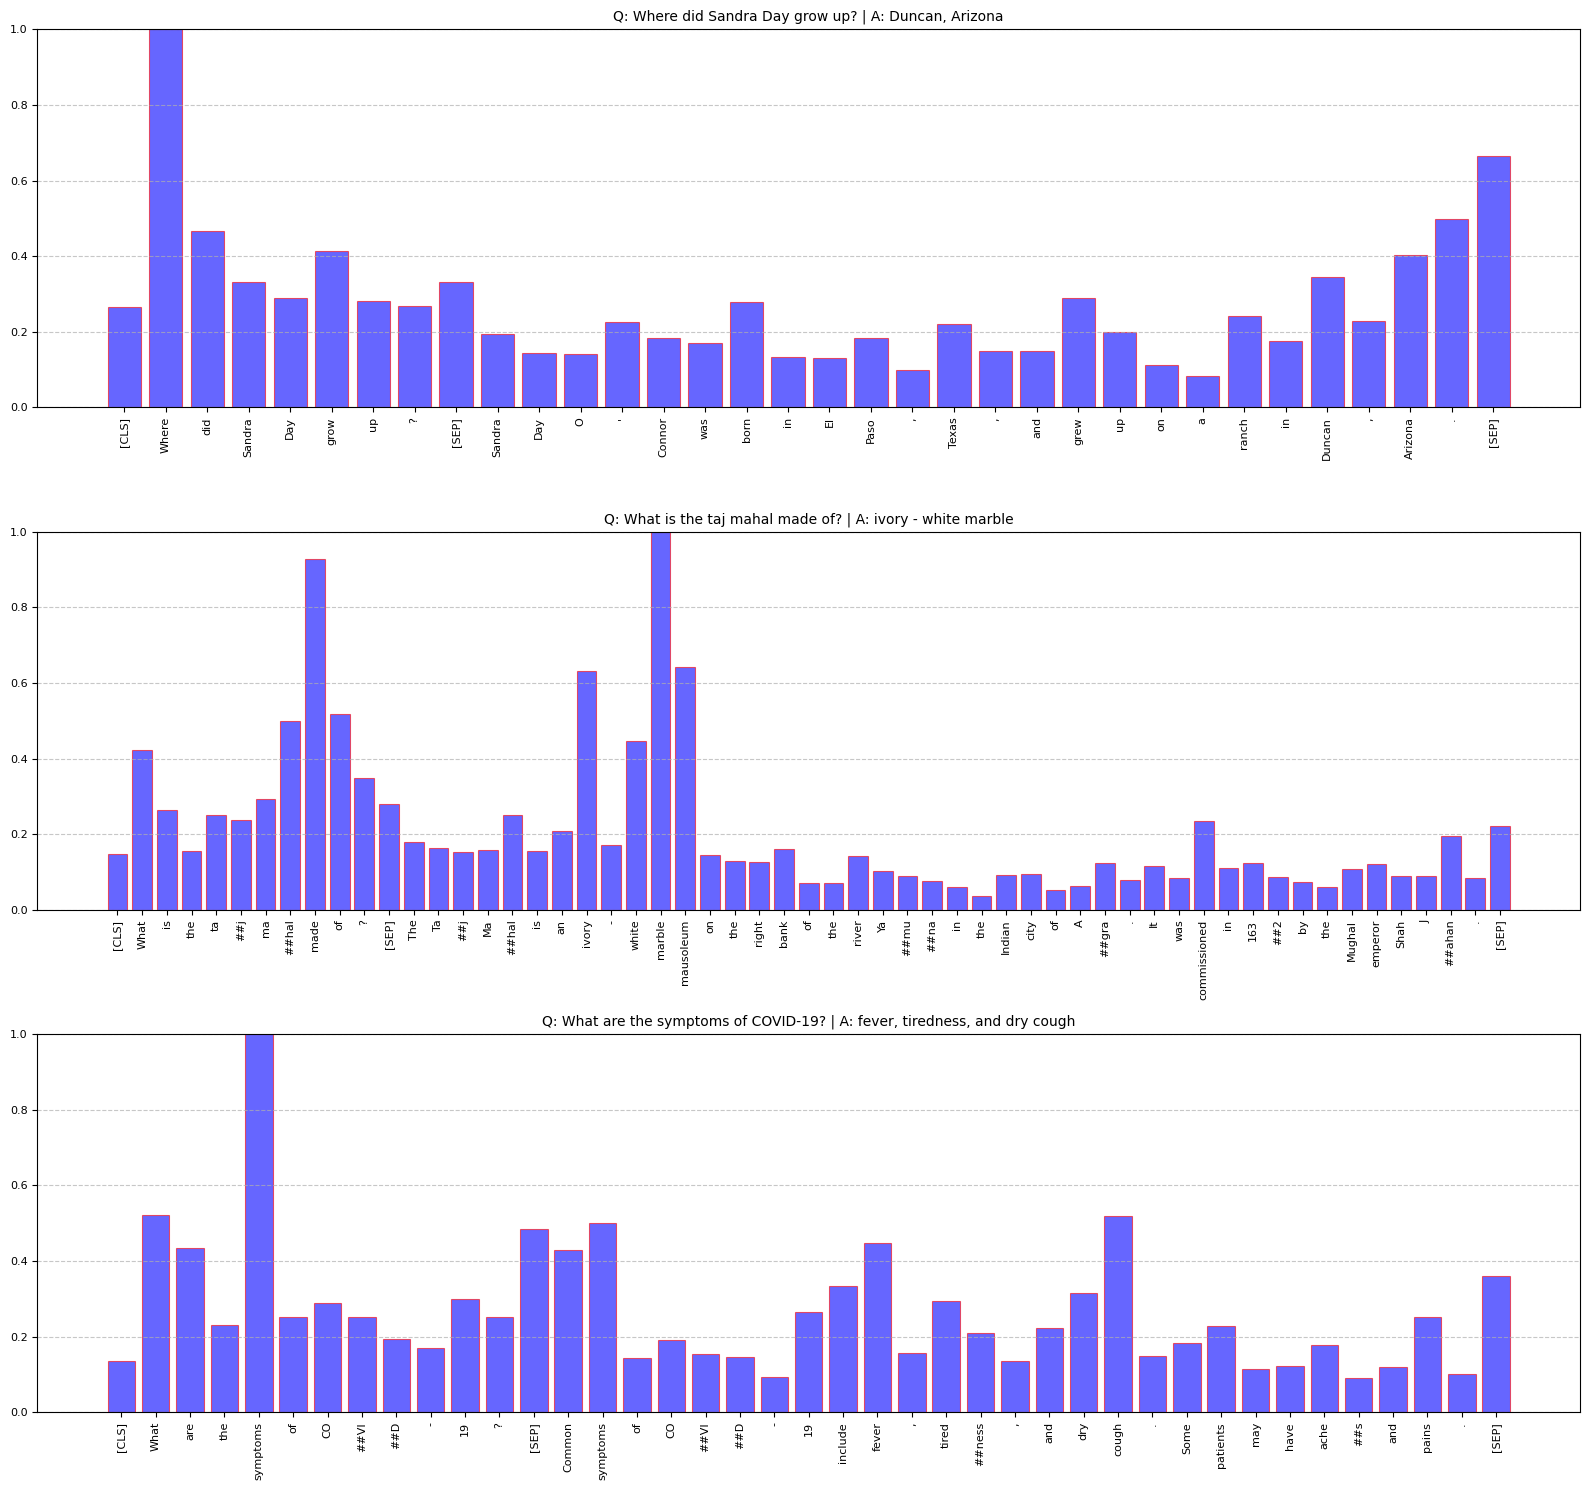

In [ ]:
from captum.attr import Saliency, IntegratedGradients

examples = [
    {
        "question": "Where did Sandra Day grow up?",
        "context": "Sandra Day O'Connor was born in El Paso, Texas, and grew up on a ranch in Duncan, Arizona."
    },
    {
        "question": "What is the taj mahal made of?",
        "context": "The Taj Mahal is an ivory-white marble mausoleum on the right bank of the river Yamuna in the Indian city of Agra. It was commissioned in 1632 by the Mughal emperor Shah Jahan."
    },
    {
        "question": "What are the symptoms of COVID-19?",
        "context": "Common symptoms of COVID-19 include fever, tiredness, and dry cough. Some patients may have aches and pains."
    }
]

# --- 3. Captum Wrapper Functions (same as before) ---
embedding_layer = model.distilbert.embeddings.word_embeddings

def saliency_forward_start(inputs_embeds, attention_mask):
    outputs = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask.to(device))
    return outputs.start_logits

def saliency_forward_end(inputs_embeds, attention_mask):
    outputs = model(inputs_embeds=inputs_embeds, attention_mask=attention_mask.to(device))
    return outputs.end_logits

# --- 4. Prediction and Attribution Calculation Function ---
def explain_qa_example(question, context, explainer_algo=Saliency):
    """
    Performs QA prediction and calculates combined saliency scores for an example.
    """
    inputs = tokenizer(question, context, return_tensors='pt', truncation=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()} # Move inputs to device

    # Get model prediction
    with torch.no_grad():
        outputs = model(**inputs)

    start_idx = torch.argmax(outputs.start_logits)
    end_idx = torch.argmax(outputs.end_logits)

    predicted_answer_tokens = inputs['input_ids'][0, start_idx : end_idx + 1]
    predicted_answer = tokenizer.decode(predicted_answer_tokens, skip_special_tokens=True)

    # Captum attributions
    # Make sure to pass a copy of the embedding, and require_grad=True
    input_embeds = embedding_layer(inputs['input_ids']).requires_grad_(True)

    # Instantiate the explainer for start and end logits
    attr_start_explainer = explainer_algo(saliency_forward_start)
    attr_end_explainer = explainer_algo(saliency_forward_end)

    # Calculate attributions
    attrs_start = attr_start_explainer.attribute(
        inputs=input_embeds,
        target=start_idx,
        additional_forward_args=(inputs['attention_mask'],) # pass attention_mask as additional arg
    )
    attrs_end = attr_end_explainer.attribute(
        inputs=input_embeds,
        target=end_idx,
        additional_forward_args=(inputs['attention_mask'],)
    )

    # Summarize attributions: take the L2 norm over the embedding dimension
    attrs_start_sum = attrs_start.norm(p=2, dim=-1).squeeze(0).detach().cpu().numpy()
    attrs_end_sum = attrs_end.norm(p=2, dim=-1).squeeze(0).detach().cpu().numpy()

    # Combine the start and end scores (e.g., by summing them)
    # You might also experiment with taking the max or a weighted sum
    combined_saliency_scores = attrs_start_sum + attrs_end_sum

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'].squeeze().cpu())

    return tokens, combined_saliency_scores, predicted_answer

# --- 5. Custom Plotting Function (similar to your example) ---
def plot_word_attribution(tokens, scores, question, predicted_answer, ax):
    """
    Plots word attribution scores as a bar chart.
    """
    # Normalize scores to 0-1 for consistent bar heights
    max_score = np.max(scores)
    if max_score == 0: # Avoid division by zero if all scores are 0
        normalized_scores = np.zeros_like(scores)
    else:
        normalized_scores = scores / max_score

    x_pos = np.arange(len(tokens))

    # Plotting bars (blue with red outline, like your example)
    ax.bar(x_pos, normalized_scores, width=0.8, color='blue', alpha=0.6, edgecolor='red', linewidth=0.8)

    # Customize ticks and labels
    ax.set_xticks(x_pos)
    ax.set_xticklabels(tokens, rotation=90, fontsize=8) # Rotate labels for readability
    ax.set_ylim(0, 1) # Scores are normalized 0-1
    ax.tick_params(axis='y', labelsize=8)

    # Set title with question and predicted answer
    ax.set_title(f"Q: {question} | A: {predicted_answer}", fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# --- Main Execution for multiple examples ---
fig, axes = plt.subplots(nrows=len(examples), figsize=(16, 5 * len(examples)))
if len(examples) == 1: # If only one example, axes is not an array
    axes = [axes]

for i, example in enumerate(examples):
    tokens, saliency_scores, predicted_answer = explain_qa_example(
        example["question"], example["context"], explainer_algo=IntegratedGradients # Choose Saliency or IntegratedGradients
    )
    plot_word_attribution(tokens, saliency_scores, example["question"], predicted_answer, axes[i])
# plt.suptitle("Lev Attention Word Attribution")
plt.tight_layout()
plt.show()